In [1]:
#*******************************************************************************************
 #
 #  File Name:  climate_analysis.ipynb
 #
 #  File Description:
 #      This interactive Python notebook, climate_analysis.ipynb, conducts  
 #      a basic precipitation data exploration and analysis of a SQLite 
 #      database through the use of SQLAlchemy ORM queries, Pandas, and
 #      Matplotlib.
 #
 #
 #  Date            Description                             Programmer
 #  ----------      ------------------------------------    ------------------
 #  09/06/2023      Initial Development                     Nicholas J. George
 #
 #******************************************************************************************/

import climate_analysis_constants

import logx
import matplotlibx
import pandasx
import timex

import datetime as dt
import pandas as pd

import sqlalchemy

from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

from pprint import pprint

pd.options.mode.chained_assignment = None

%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import style

style.use('fivethirtyeight')

In [2]:
CONSTANT_LOCAL_FILE_NAME = 'climate_analysis.ipynb'


logx.set_log_mode(False)

logx.set_image_mode(False)


logx.begin_program('climate_analysis')

# <br> **Section 1: Reflect Tables into SQLAlchemy ORM**

## **1.1: SQLAlchemy Engine**

In [3]:
# This line of code uses SQLAlchemy's function, create_engine, to connect 
# to climate database, hawaii.sqlite, containing precipitation data from
# Honolulu, Hawaii.
engine_sqlalchemy = create_engine(climate_analysis_constants.CONSTANT_SQLITE_DATABASE_FILE)

logx.log_write_object(engine_sqlalchemy)

## **1.2: Database Reflection**

In [4]:
# This line of code sets up the tables in a climate database for reflection
# into classes.
base_classes_sqlalchemy = automap_base()

logx.log_write_object(base_classes_sqlalchemy)

In [5]:
# This line of code creates an SQLAlchemy inspection object, which delivers 
# runtime information about a wide variety of SQLAlchemy objects.
inspector_sqlalchemy = inspect(engine_sqlalchemy)

logx.log_write_object(inspector_sqlalchemy)

## **1.3: Database Table Metadata**

In [6]:
# This line of code reflects the database tables into classes.
base_classes_sqlalchemy.prepare(autoload_with = engine_sqlalchemy)

# This line of code uses the SQLAlchemy's function, automap, to populate the classes.
base_classes_sqlalchemy.classes.keys()

['measurement', 'station']

In [7]:
# This line of code saves the station table reference.
stations_class_sqlalchemy = base_classes_sqlalchemy.classes.station

logx.log_write_object(stations_class_sqlalchemy)

In [8]:
# This line of code saves the table, measurements, reference.
measurements_class_sqlalchemy = base_classes_sqlalchemy.classes.measurement

logx.log_write_object(measurements_class_sqlalchemy)

## **1.4: Create Session**

In [9]:
# This line of code creates an SQLAlchemy session.
session_sqlalchemy = Session(engine_sqlalchemy)

logx.log_write_object(session_sqlalchemy)

# <br> **Section 2: Exploratory Station Analysis**

## **2.1: Date Ranges**

### **Query Results**

In [10]:
first_dates_string_list \
    = session_sqlalchemy \
        .query(measurements_class_sqlalchemy.date) \
        .order_by(measurements_class_sqlalchemy.date.asc()) \
        .first()

last_dates_string_list \
    = session_sqlalchemy \
        .query(measurements_class_sqlalchemy.date) \
        .order_by(measurements_class_sqlalchemy.date.desc()) \
        .first()


first_date_string = first_dates_string_list[0]

last_date_string = last_dates_string_list[0]


logx.print_and_log_text \
    ('\033[1m' \
     + f'This data set extends from {first_date_string} ' \
     + f'to {last_date_string}.' \
     + '\033[0m')

This data set extends from 2010-01-01 to 2017-08-23.


### **Display Date One Year Prior to Last Date**

In [11]:
one_year_prior_date_string = timex.return_prior_date_days(last_date_string, 365)

logx.print_and_log_text \
    ('\033[1m' \
     + 'The date one year prior to the last date in the data set is ' \
     + f'{one_year_prior_date_string}.' \
     + '\033[0m')

The date one year prior to the last date in the data set is 2016-08-23.


## **2.2: Total Number of Stations**

In [12]:
total_station_count_integer \
    = session_sqlalchemy \
        .query(stations_class_sqlalchemy) \
        .group_by(stations_class_sqlalchemy.station) \
        .count()

logx.print_and_log_text \
    ('\033[1m' \
     + 'The total number of stations in the dataset is ' \
     + '{:,}.'.format(total_station_count_integer) \
     + '\033[0m')

The total number of stations in the dataset is 9.


## **2.3: Most Active Station IDs**

### **Query Results**

In [13]:
most_active_stations_dictionary = {}

for index, key in enumerate(climate_analysis_constants.year_string_list): 

    most_active_stations_tuple_list \
        = session_sqlalchemy \
            .query(measurements_class_sqlalchemy.station, func.count(measurements_class_sqlalchemy.station)) \
            .group_by(measurements_class_sqlalchemy.station) \
            .order_by(func.count(measurements_class_sqlalchemy.station).desc()) \
            .filter(measurements_class_sqlalchemy.date >= climate_analysis_constants.first_dates_string_list[index]) \
            .filter(measurements_class_sqlalchemy.date <= climate_analysis_constants.last_dates_string_list[index]) \
            .all()

    most_active_stations_dictionary[key] \
        = [most_active_stations_tuple_list[0][0],
           most_active_stations_tuple_list[0][1]]
    
    logx.log_write_object(most_active_stations_tuple_list)

logx.log_write_object(most_active_stations_dictionary)

### **Save Query Results to DataFrame**

In [14]:
most_active_stations_dataframe \
    = pd.DataFrame.from_dict \
        (most_active_stations_dictionary, 
         orient = 'index', 
         columns = ['station_id', 'tobs'])

most_active_stations_dataframe.index.name = 'year'

logx.log_write_object(most_active_stations_dataframe)

### **Display Most Active Station IDs By Year**

In [15]:
pandasx.return_formatted_table \
    (most_active_stations_dataframe, 
     'Table 2.3: Most Active Station IDs and TOBS By Year', 
     hide_index_boolean = False)

,station_id,tobs
year,,
2010,USC00519281,364
2011,USC00519523,362
2012,USC00519281,366
2013,USC00519397,365
2014,USC00519281,365
2015,USC00519397,364
2016,USC00519397,366
2017*,USC00519397,230


## **2.4: Minimum, Maximum, and Average Temperatures**

### **Query Results**

In [16]:
minimum_temperatures_float_list = []

maximum_temperatures_float_list = []

mean_temperatures_float_list = []

for index, key in enumerate(climate_analysis_constants.year_string_list): 
    
    minimum_temperature_float \
        = session_sqlalchemy \
            .query(func.min(measurements_class_sqlalchemy.tobs)) \
            .filter(measurements_class_sqlalchemy.date >= climate_analysis_constants.first_dates_string_list[index]) \
            .filter(measurements_class_sqlalchemy.date <= climate_analysis_constants.last_dates_string_list[index]) \
            .filter(measurements_class_sqlalchemy.station == most_active_stations_dictionary[key][0]) \
            .first()[0]
    
    maximum_temperature_float \
        = session_sqlalchemy \
            .query(func.max(measurements_class_sqlalchemy.tobs)) \
            .filter(measurements_class_sqlalchemy.date >= climate_analysis_constants.first_dates_string_list[index]) \
            .filter(measurements_class_sqlalchemy.date <= climate_analysis_constants.last_dates_string_list[index]) \
            .filter(measurements_class_sqlalchemy.station == most_active_stations_dictionary[key][0]) \
            .first()[0]
    
    mean_temperature_float \
        = session_sqlalchemy \
            .query(func.avg(measurements_class_sqlalchemy.tobs)) \
            .filter(measurements_class_sqlalchemy.date >= climate_analysis_constants.first_dates_string_list[index]) \
            .filter(measurements_class_sqlalchemy.date <= climate_analysis_constants.last_dates_string_list[index]) \
            .filter(measurements_class_sqlalchemy.station == most_active_stations_dictionary[key][0]) \
            .first()[0]
    
    minimum_temperatures_float_list.append(round(minimum_temperature_float, 1))
    
    maximum_temperatures_float_list.append(round(maximum_temperature_float, 1))

    mean_temperatures_float_list.append(round(mean_temperature_float, 1))

### **Save Query Results to DataFrame**

In [17]:
temperatures_dataframe \
    = pd.DataFrame \
        (list(zip(minimum_temperatures_float_list, maximum_temperatures_float_list, mean_temperatures_float_list)),
         columns = ['minimum', 'maximum', 'mean'], 
         index = list(most_active_stations_dictionary.keys()))

logx.log_write_object(temperatures_dataframe)

### **Display Minimum, Maximum, and Average Temperatures By Year**

In [18]:
pandasx.return_formatted_table \
    (temperatures_dataframe, 
     'Table 2.4: Minimum, Maximum, and Average Temperatures By Year',
     hide_index_boolean = False) \
        .format({'minimum': '{:,.1f} °F',
                 'maximum': '{:,.1f} °F',
                 'mean': '{:,.1f} °F'})

,minimum,maximum,mean
2010,58.0 °F,82.0 °F,71.3 °F
2011,58.0 °F,84.0 °F,74.3 °F
2012,60.0 °F,82.0 °F,71.2 °F
2013,58.0 °F,84.0 °F,74.0 °F
2014,57.0 °F,81.0 °F,70.8 °F
2015,58.0 °F,84.0 °F,75.3 °F
2016,61.0 °F,82.0 °F,74.5 °F
2017*,60.0 °F,87.0 °F,74.9 °F


<Figure size 970.8x600 with 0 Axes>

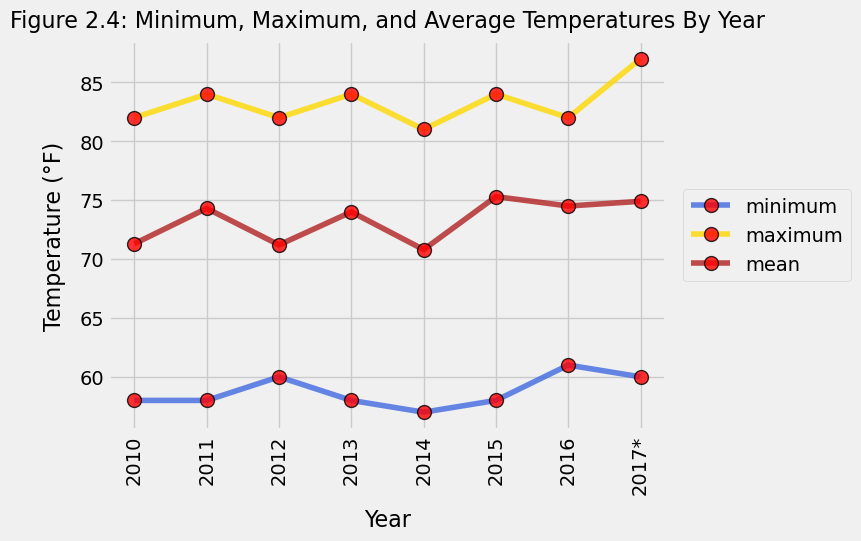

In [19]:
matplotlibx.display_line_chart_from_dataframe \
    (temperatures_dataframe,
     'Figure 2.4: Minimum, Maximum, and Average Temperatures By Year',
     ['royalblue', 'gold','firebrick'], 'Year', 'Temperature (°F)',
     marker_size_float = 10.0, display_legend_boolean = True,
     legend_bbox_to_anchor_float_tuple = (1.35, 0.5))

# <br> **Section 3: Exploratory Temperature Observations (TOBs) Analysis**

## **3.1: Query Results**

In [20]:
tobs_series_list = []

for index, value in enumerate(climate_analysis_constants.year_string_list): 

    query_results_tuple_list \
        = session_sqlalchemy \
            .query(measurements_class_sqlalchemy.date, measurements_class_sqlalchemy.tobs) \
            .filter(measurements_class_sqlalchemy.date >= climate_analysis_constants.first_dates_string_list[index]) \
            .filter(measurements_class_sqlalchemy.date <= climate_analysis_constants.last_dates_string_list[index]) \
            .filter(measurements_class_sqlalchemy.station == most_active_stations_dictionary[value][0]) \
            .all()

    
    query_results_dataframe = pd.DataFrame(query_results_tuple_list, columns = ['date', 'tobs'])
        
    query_results_dataframe.dropna(axis = 0, how = 'any', inplace = True)
    
    query_results_dataframe.set_index('date', drop = True, append = False, inplace = True, verify_integrity = False)

    query_results_dataframe.sort_values(by = 'date', axis = 0, inplace = True)

    
    query_results_series = query_results_dataframe.squeeze()

    query_results_series.name = value

    
    tobs_series_list.append(query_results_series)
    
    logx.log_write_object(query_results_tuple_list)


logx.log_write_object(tobs_series_list)

## **3.2: Temperature Observations (TOBs) (2010)**

### **Histogram**

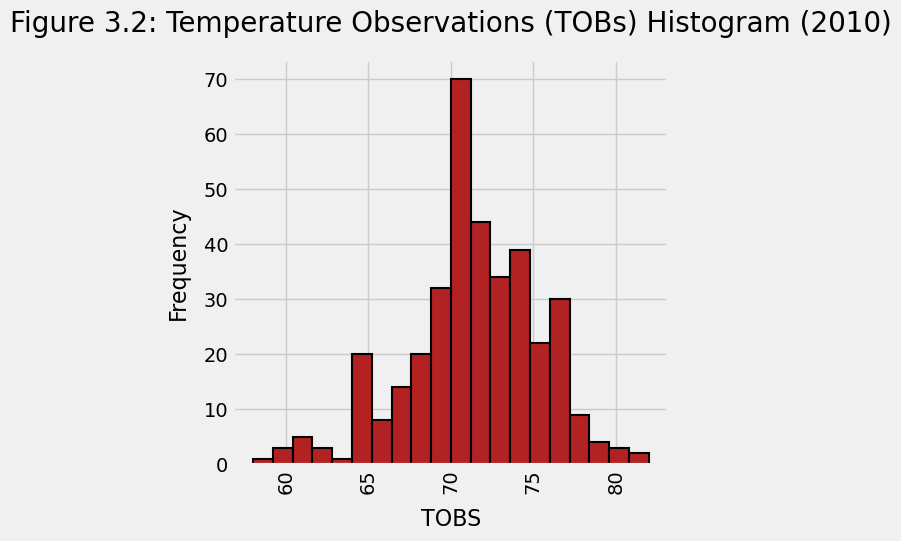

In [21]:
matplotlibx.display_histogram_from_series \
    (tobs_series_list[0],
     'Figure 3.2: Temperature Observations (TOBs) Histogram (2010)',
     ['firebrick'], 'TOBS', 'Frequency',  
     figure_width_float = 5.0, figure_length_float = 5.0)

### **Summary Statistics**

In [22]:
pandasx.return_statistics_styler_from_series \
    (tobs_series_list[0], 'Table 3.2: Temperature Observations (TOBs) Statistics (2010)')

,2010
mean,71.3049
median,72.0000
mode,72.0000
variance,16.1299
std_dev,4.0162
sem,0.2105
minimum,58.00
25%,69.00
50%,72.00
75%,74.00


## **3.3: Temperature Observations (TOBs) (2011)**

 ### **Histogram**

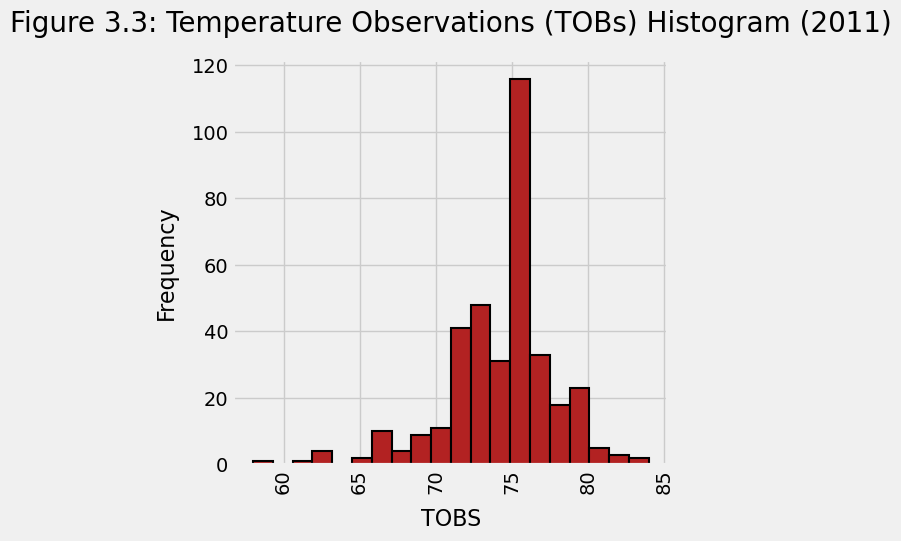

In [23]:
matplotlibx.display_histogram_from_series \
    (tobs_series_list[1],
     'Figure 3.3: Temperature Observations (TOBs) Histogram (2011)',
     ['firebrick'], 'TOBS', 'Frequency',  
     figure_width_float = 5.0, figure_length_float = 5.0)

### **Summary Statistics**

In [24]:
pandasx.return_statistics_styler_from_series \
    (tobs_series_list[1], 'Table 3.3: Temperature Observations (TOBs) Statistics (2011)')

,2011
mean,74.3425
median,75.0000
mode,76.0000
variance,12.8352
std_dev,3.5826
sem,0.1883
minimum,58.00
25%,73.00
50%,75.00
75%,76.00


## **3.4: Temperature Observations (TOBs) (2012)**

### **Histogram**

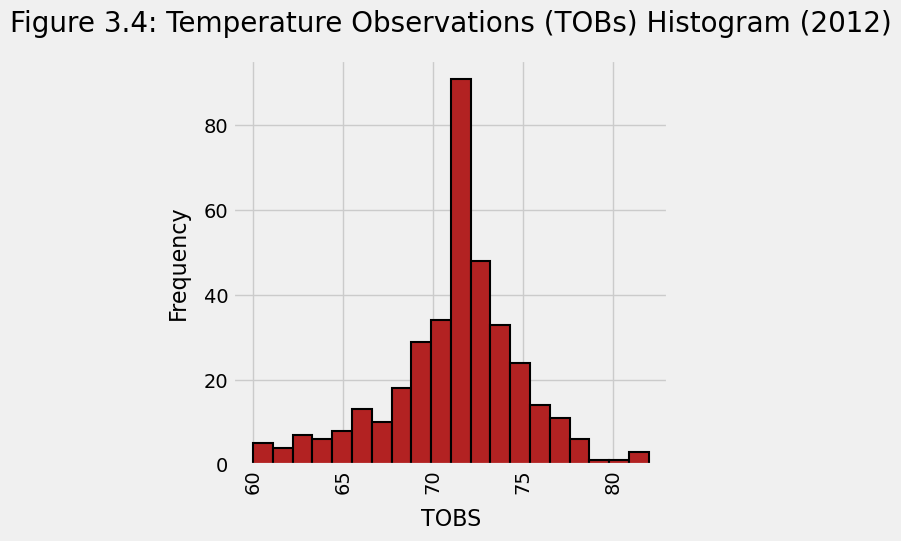

In [25]:
matplotlibx.display_histogram_from_series \
    (tobs_series_list[2],
     'Figure 3.4: Temperature Observations (TOBs) Histogram (2012)',
     ['firebrick'], 'TOBS', 'Frequency',  
     figure_width_float = 5.0, figure_length_float = 5.0)

### **Summary Statistics**

In [26]:
pandasx.return_statistics_styler_from_series \
    (tobs_series_list[2], 'Table 3.4: Temperature Observations (TOBs) Statistics (2012)')

,2012
mean,71.2186
median,72.0000
mode,73.0000
variance,13.9740
std_dev,3.7382
sem,0.1954
minimum,60.00
25%,69.00
50%,72.00
75%,74.00


## **3.5: Temperature Observations (TOBs) (2013)**

### **Histogram**

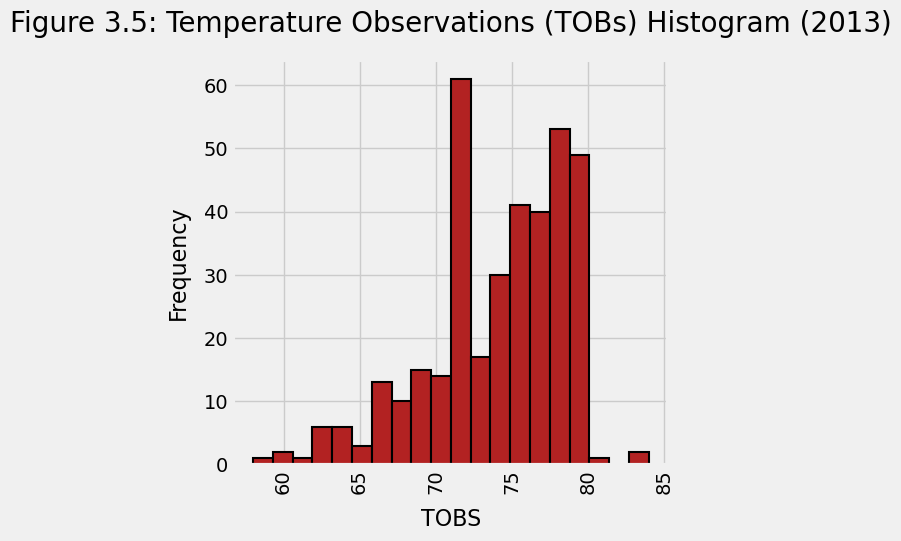

In [27]:
matplotlibx.display_histogram_from_series \
    (tobs_series_list[3],
     'Figure 3.5: Temperature Observations (TOBs) Histogram (2013)',
     ['firebrick'], 'TOBS', 'Frequency',  
     figure_width_float = 5.0, figure_length_float = 5.0)

### **Summary Statistics**

In [28]:
pandasx.return_statistics_styler_from_series \
    (tobs_series_list[3], 'Table 3.5: Temperature Observations (TOBs) Statistics (2013)')

,2013
mean,74.0000
median,75.0000
mode,78.0000
variance,20.4011
std_dev,4.5168
sem,0.2364
minimum,58.00
25%,71.00
50%,75.00
75%,78.00


## **3.6: Temperature Observations (TOBs) (2014)**

### **Histogram**

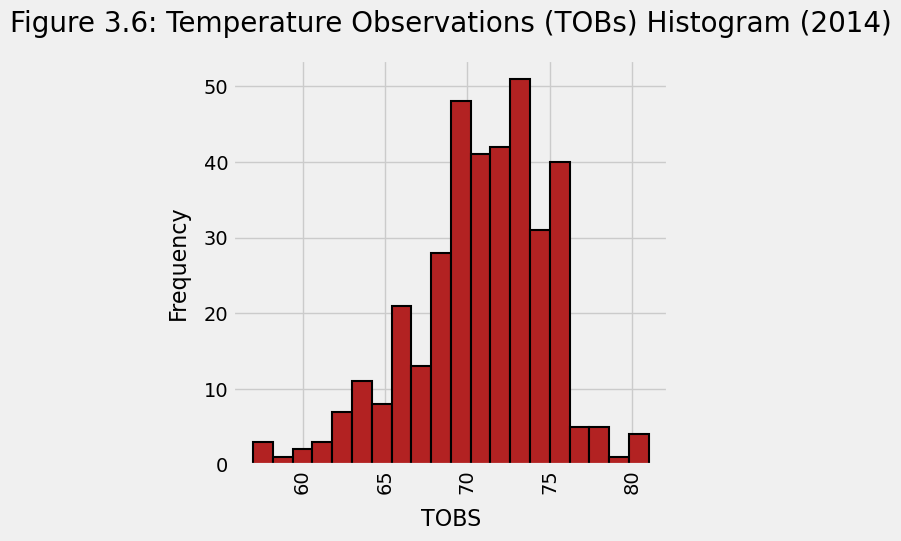

In [29]:
matplotlibx.display_histogram_from_series \
    (tobs_series_list[4],
     'Figure 3.6: Temperature Observations (TOBs) Histogram (2014)',
     ['firebrick'], 'TOBS', 'Frequency',  
     figure_width_float = 5.0, figure_length_float = 5.0)

### **Summary Statistics**

In [30]:
pandasx.return_statistics_styler_from_series \
    (tobs_series_list[4], 'Table 3.6: Temperature Observations (TOBs) Statistics (2014)')

,2014
mean,70.7589
median,71.0000
mode,73.0000
variance,16.1560
std_dev,4.0195
sem,0.2104
minimum,57.00
25%,68.00
50%,71.00
75%,73.00


## **3.7: Temperature Observations (TOBs) (2015)**

### **Histogram**

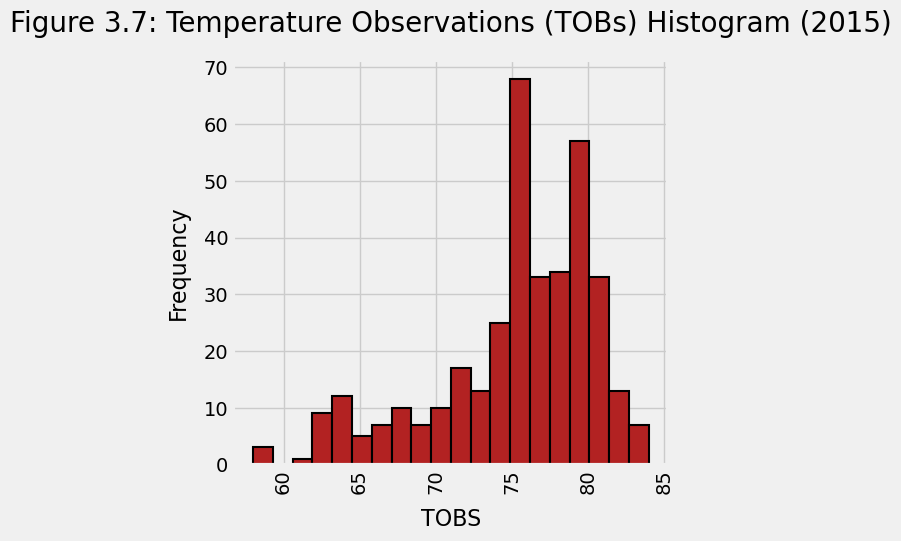

In [31]:
matplotlibx.display_histogram_from_series \
    (tobs_series_list[5],
     'Figure 3.7: Temperature Observations (TOBs) Histogram (2015)',
     ['firebrick'], 'TOBS', 'Frequency',  
     figure_width_float = 5.0, figure_length_float = 5.0)

### **Summary Statistics**

In [32]:
pandasx.return_statistics_styler_from_series \
    (tobs_series_list[5], 'Table 3.7: Temperature Observations (TOBs) Statistics (2015)')

,2015
mean,75.3104
median,76.0000
mode,76.0000
variance,27.4874
std_dev,5.2428
sem,0.2748
minimum,58.00
25%,73.00
50%,76.00
75%,79.00


## **3.8: Temperature Observations (TOBs) (2016)**

### **Histogram**

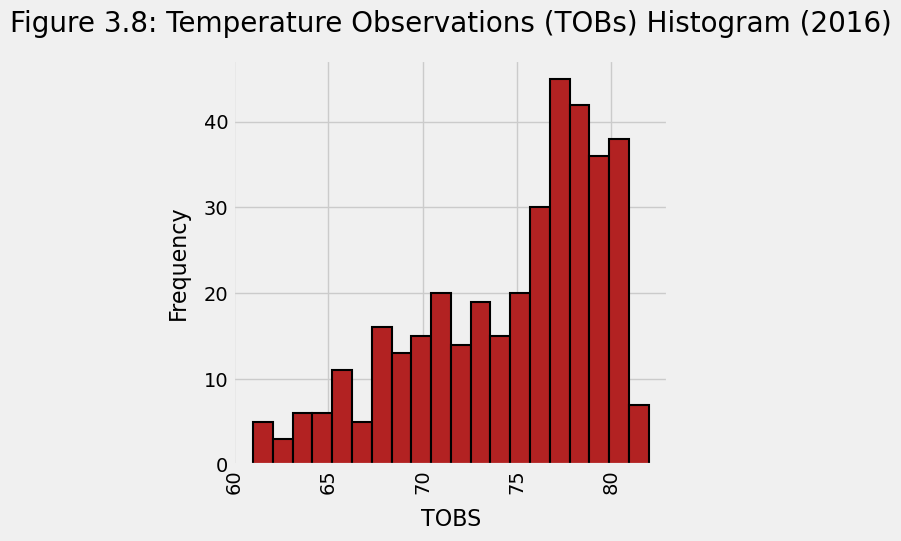

In [33]:
matplotlibx.display_histogram_from_series \
    (tobs_series_list[6],
     'Figure 3.8: Temperature Observations (TOBs) Histogram (2016)',
     ['firebrick'], 'TOBS', 'Frequency',  
     figure_width_float = 5.0, figure_length_float = 5.0)

### **Summary Statistics**

In [34]:
pandasx.return_statistics_styler_from_series \
    (tobs_series_list[6], 'Table 3.8: Temperature Observations (TOBs) Statistics (2016)')

,2016
mean,74.4973
median,76.0000
mode,77.0000
variance,22.7164
std_dev,4.7662
sem,0.2491
minimum,61.00
25%,71.00
50%,76.00
75%,78.00


## **3.9: Temperature Observations (TOBs) (2017 - 8 Months)**

### **Histogram**

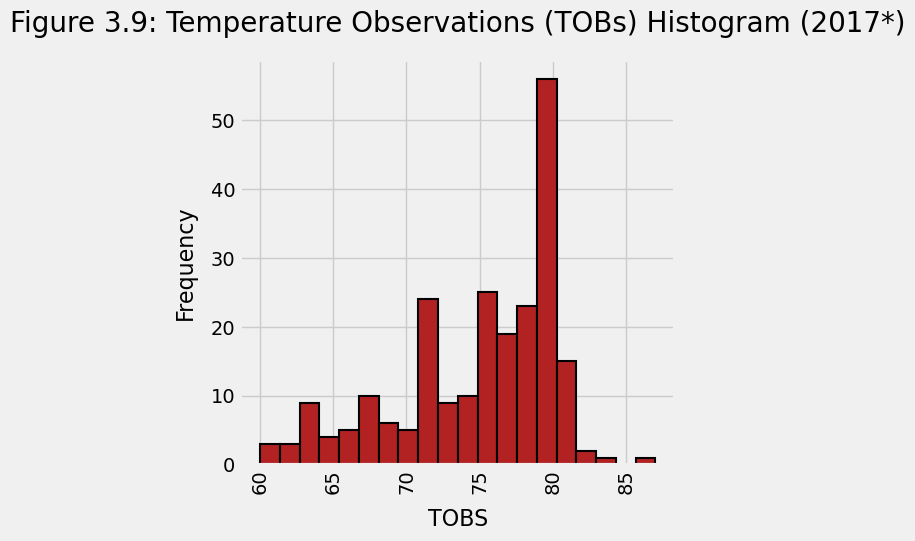

In [35]:
matplotlibx.display_histogram_from_series \
    (tobs_series_list[7],
     'Figure 3.9: Temperature Observations (TOBs) Histogram (2017*)',
     ['firebrick'], 'TOBS', 'Frequency',  
     figure_width_float = 5.0, figure_length_float = 5.0)

### **Summary Statistics**

In [36]:
pandasx.return_statistics_styler_from_series \
    (tobs_series_list[7], 'Table 3.9: Temperature Observations (TOBs) Statistics (2017*)')

,2017*
mean,74.9261
median,77.0000
mode,80.0000
variance,29.2041
std_dev,5.4041
sem,0.3563
minimum,60.00
25%,72.00
50%,77.00
75%,79.00


## **3.10: Temperature Observations (TOBs) (2010-2017)**

### **Histogram**

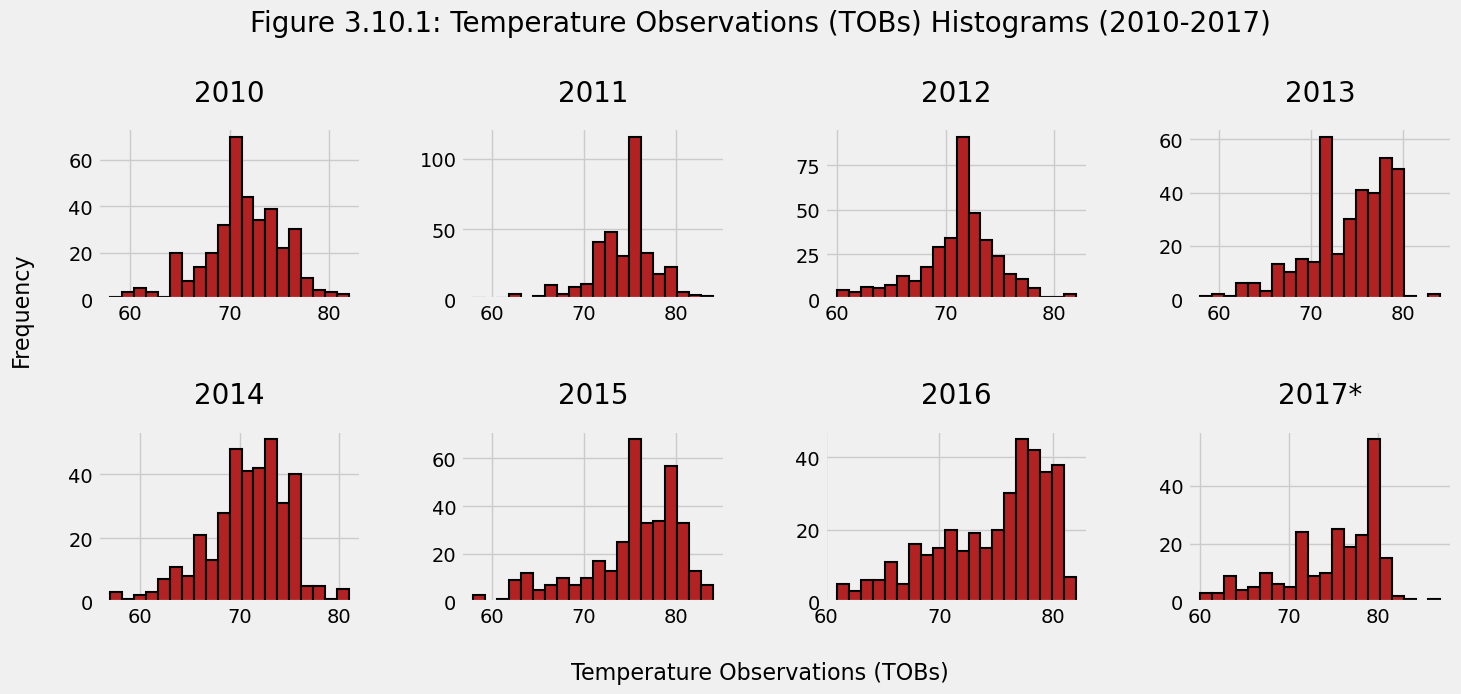

In [37]:
matplotlibx.display_histograms_from_series_list \
    (tobs_series_list,
     'Figure 3.10.1: Temperature Observations (TOBs) Histograms (2010-2017)',
     'Temperature Observations (TOBs)',
     'Frequency')

### **Box Plot**

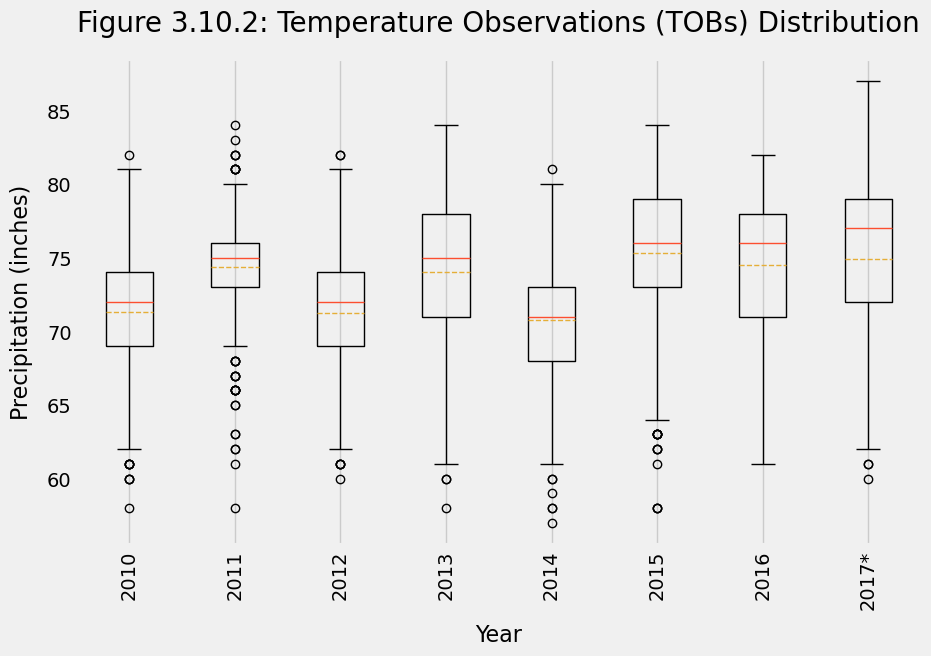

In [38]:
matplotlibx.display_boxplots_from_series_list \
    (tobs_series_list, climate_analysis_constants.year_string_list, 
     'Figure 3.10.2: Temperature Observations (TOBs) Distribution',
     'Year', 'Precipitation (inches)', xticks_rotation_float = 90.0)

### **Summary Statistics**

In [39]:
pandasx.return_statistics_styler_from_series_list \
    (tobs_series_list, 'Table 3.10.1: Temperature Observations (TOBs) Statistics (2010-2017)')

,2010,2011,2012,2013,2014,2015,2016,2017*
mean,71.3049,74.3425,71.2186,74.0000,70.7589,75.3104,74.4973,74.9261
median,72.0000,75.0000,72.0000,75.0000,71.0000,76.0000,76.0000,77.0000
mode,72.0000,76.0000,73.0000,78.0000,73.0000,76.0000,77.0000,80.0000
variance,16.1299,12.8352,13.9740,20.4011,16.1560,27.4874,22.7164,29.2041
std_dev,4.0162,3.5826,3.7382,4.5168,4.0195,5.2428,4.7662,5.4041
sem,0.2105,0.1883,0.1954,0.2364,0.2104,0.2748,0.2491,0.3563
minimum,58.00,58.00,60.00,58.00,57.00,58.00,61.00,60.00
25%,69.00,73.00,69.00,71.00,68.00,73.00,71.00,72.00
50%,72.00,75.00,72.00,75.00,71.00,76.00,76.00,77.00
75%,74.00,76.00,74.00,78.00,73.00,79.00,78.00,79.00


### **Correlation Matrix**

In [40]:
omit_series_index = len(tobs_series_list) - 1

normalized_tobs_dataframe \
    = timex.return_normalized_series_list_as_dataframe(tobs_series_list, [omit_series_index])

pandasx.return_formatted_table \
    (normalized_tobs_dataframe.corr(), 
     'Table 3.10.2: Temperature Observations (TOBs) Correlation Matrix (2010-2016)',
     hide_index_boolean = False)

,2010,2011,2012,2013,2014,2015,2016
2010,1.00,0.38,0.23,0.45,0.30,0.43,0.48
2011,0.38,1.00,0.35,0.47,0.39,0.52,0.57
2012,0.23,0.35,1.00,0.32,0.33,0.43,0.41
2013,0.45,0.47,0.32,1.00,0.52,0.64,0.66
2014,0.30,0.39,0.33,0.52,1.00,0.55,0.59
2015,0.43,0.52,0.43,0.64,0.55,1.00,0.72
2016,0.48,0.57,0.41,0.66,0.59,0.72,1.00


# <br> **Section 4: Exploratory Precipitation Analysis**

## **4.1: Query Results**

### **Query Results**

In [41]:
precipitation_series_list = []

for index, value in enumerate(climate_analysis_constants.year_string_list):
    
    query_results_tuple_list \
        = session_sqlalchemy \
            .query(measurements_class_sqlalchemy.date, measurements_class_sqlalchemy.prcp) \
            .filter(measurements_class_sqlalchemy.date >= climate_analysis_constants.first_dates_string_list[index]) \
            .filter(measurements_class_sqlalchemy.date <= climate_analysis_constants.last_dates_string_list[index]) \
            .filter(measurements_class_sqlalchemy.station == most_active_stations_dictionary[value][0]) \
            .all()

    query_results_dataframe = pd.DataFrame(query_results_tuple_list, columns = ['date', 'precipitation'])
        
    query_results_dataframe.dropna(axis = 0, how = 'any', inplace = True)
    
    query_results_dataframe.set_index('date', drop = True, append = False, inplace = True, verify_integrity = False)

    query_results_dataframe.sort_values(by = 'date', axis = 0, inplace = True)

    
    query_results_series = query_results_dataframe.squeeze()

    query_results_series.name = value


    climate_analysis_constants.total_precipitation_dictionary[value] = round(query_results_series.sum(), 2)
    
    
    precipitation_series_list.append(query_results_series)
    
    logx.log_write_object(query_results_tuple_list)


logx.log_write_object(precipitation_series_list)

## **4.2: Precipitation (2010)**

### **Display Precipitation vs. Time**

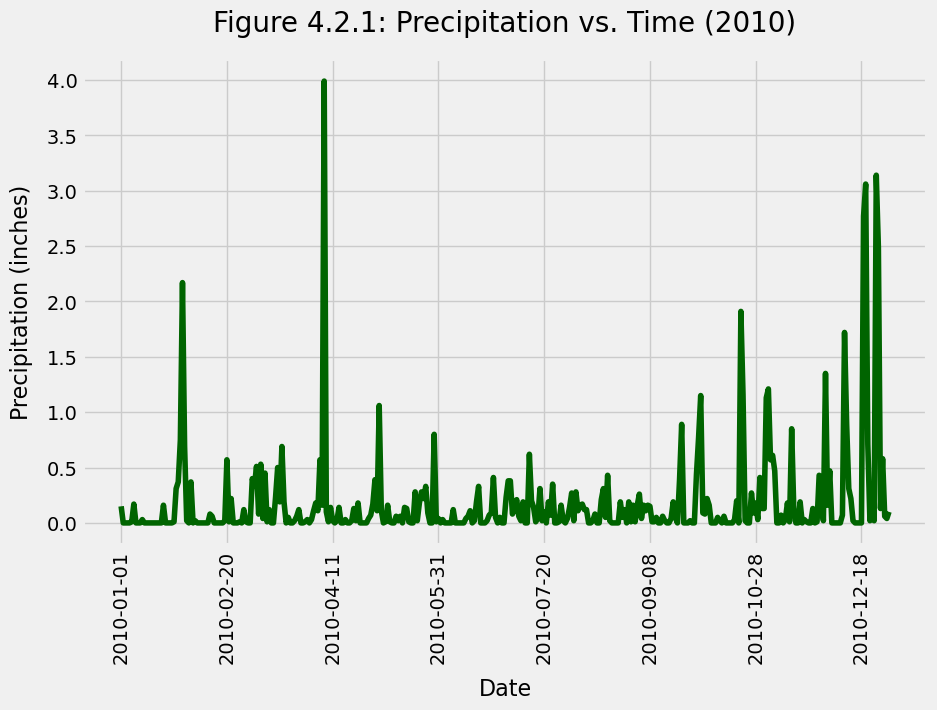

In [42]:
matplotlibx.display_plot_from_series \
    (precipitation_series_list[0], 'Figure 4.2.1: Precipitation vs. Time (2010)',
     'darkgreen', 'Date', 'Precipitation (inches)')

### **Histogram**

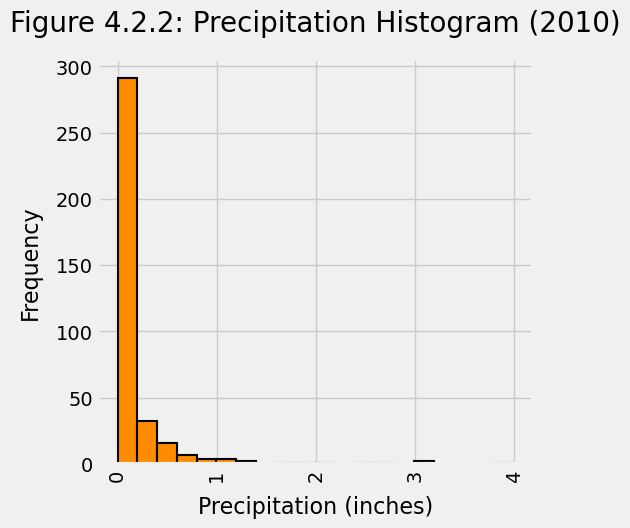

In [43]:
matplotlibx.display_histogram_from_series \
    (precipitation_series_list[0],
     'Figure 4.2.2: Precipitation Histogram (2010)',
     ['darkorange'], 'Precipitation (inches)', 'Frequency',  
     figure_width_float = 5.0, figure_length_float = 5.0)

### **Summary Statistics**

In [44]:
pandasx.return_statistics_styler_from_series \
    (precipitation_series_list[0], 'Table 4.2: Precipitation (2010) Summary Statistics')

,2010
mean,0.1805
median,0.0250
mode,0.0000
variance,0.1962
std_dev,0.4429
sem,0.0232
minimum,0.00
25%,0.00
50%,0.03
75%,0.16


## **4.3: Precipitation (2011)**

### **Display Precipitation vs. Time**

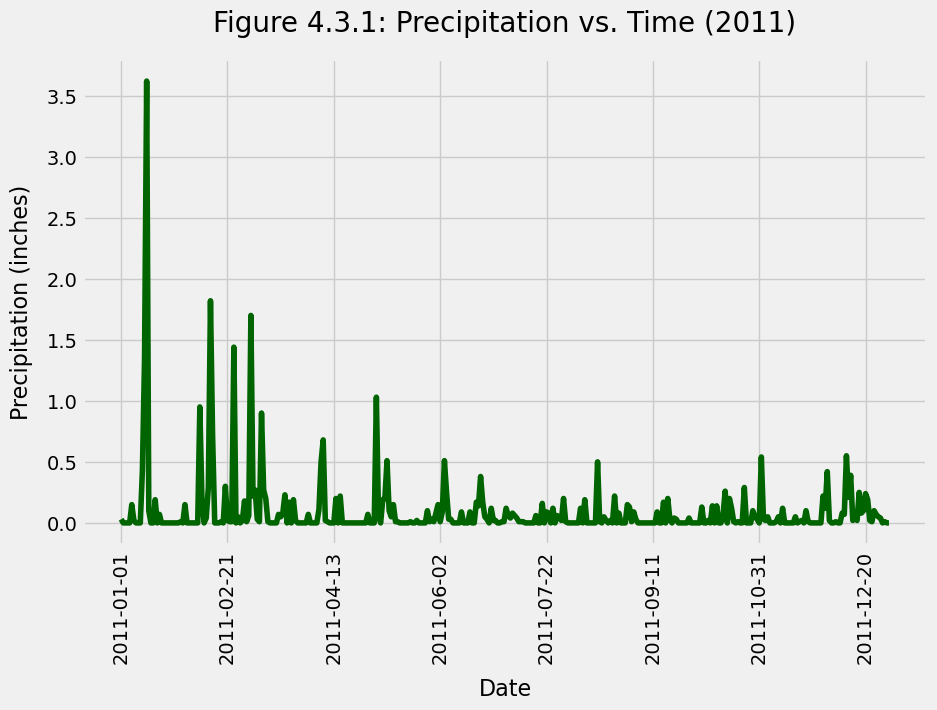

In [45]:
matplotlibx.display_plot_from_series \
    (precipitation_series_list[1], 'Figure 4.3.1: Precipitation vs. Time (2011)',
     'darkgreen', 'Date', 'Precipitation (inches)')

### **Histogram**

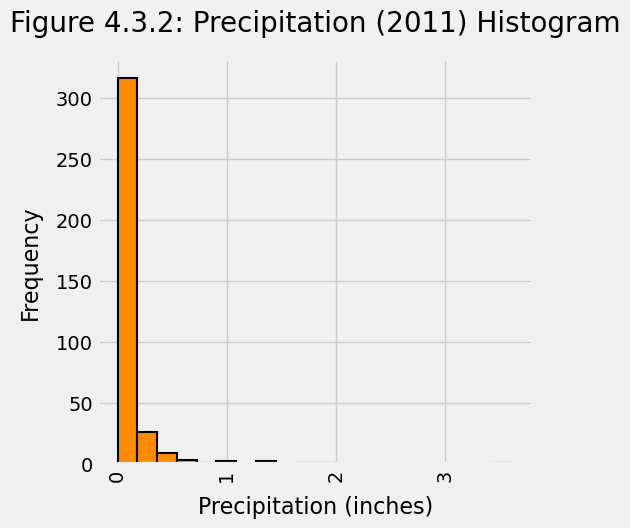

In [46]:
matplotlibx.display_histogram_from_series \
    (precipitation_series_list[1],
     'Figure 4.3.2: Precipitation (2011) Histogram',
     ['darkorange'], 'Precipitation (inches)', 'Frequency',  
     figure_width_float = 5.0, figure_length_float = 5.0)

### **Summary Statistics**

In [47]:
pandasx.return_statistics_styler_from_series \
    (precipitation_series_list[1], 'Table 4.3: Precipitation (2011) Summary Statistics')

,2011
mean,0.0909
median,0.0050
mode,0.0000
variance,0.0786
std_dev,0.2803
sem,0.0147
minimum,0.00
25%,0.00
50%,0.01
75%,0.08


## **4.4: Precipitation (2012)**

### **Display Precipitation vs. Time**

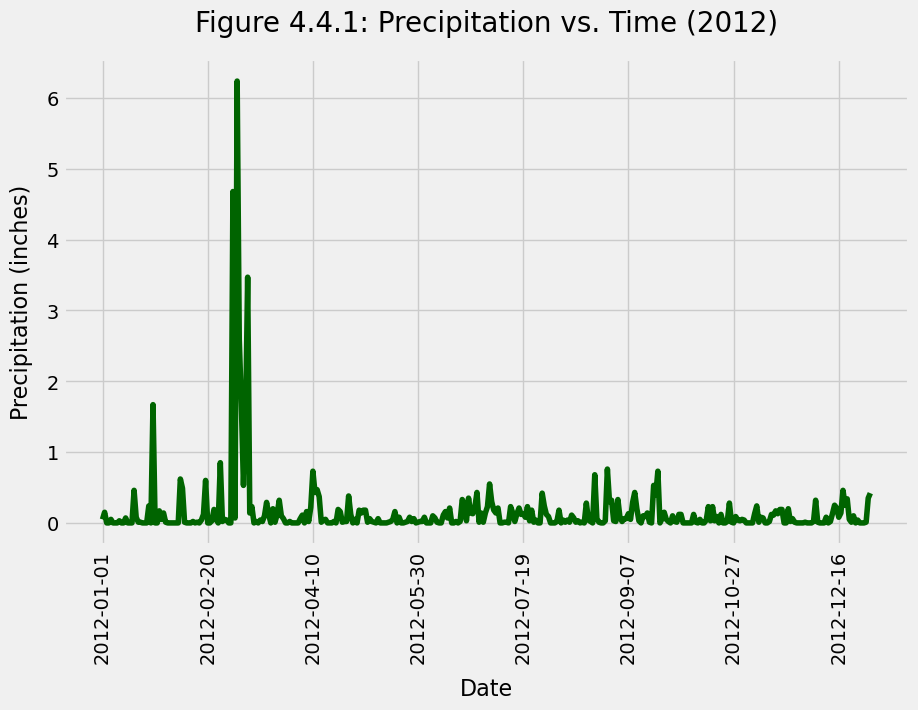

In [48]:
matplotlibx.display_plot_from_series \
    (precipitation_series_list[2], 'Figure 4.4.1: Precipitation vs. Time (2012)',
     'darkgreen', 'Date', 'Precipitation (inches)')

### **Histogram**

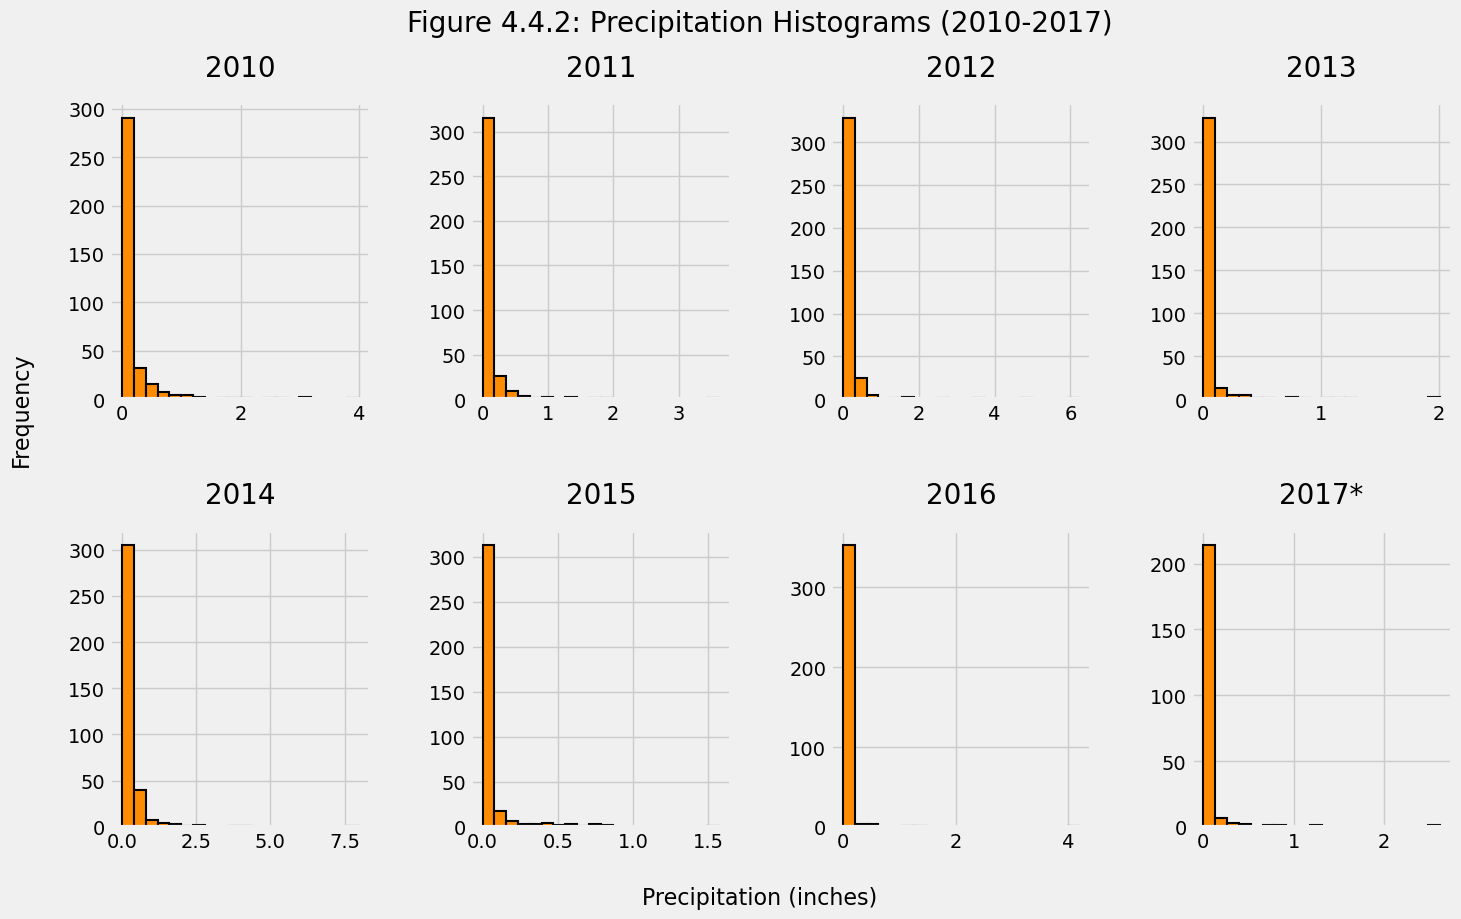

In [49]:
matplotlibx.display_histograms_from_series_list \
    (precipitation_series_list, 'Figure 4.4.2: Precipitation Histograms (2010-2017)', 
     'Precipitation (inches)', 'Frequency', color_string = 'darkorange', 
     figure_width_float = 15.0, figure_length_float = 10.0)

### **Summary Statistics**

In [50]:
pandasx.return_statistics_styler_from_series \
    (precipitation_series_list[2], 'Table 4.4: Precipitation (2012) Summary Statistics')

,2012
mean,0.1500
median,0.0300
mode,0.0000
variance,0.2453
std_dev,0.4952
sem,0.0259
minimum,0.00
25%,0.00
50%,0.03
75%,0.14


## **4.5: Precipitation (2013)**

### **Display Precipitation vs. Time**

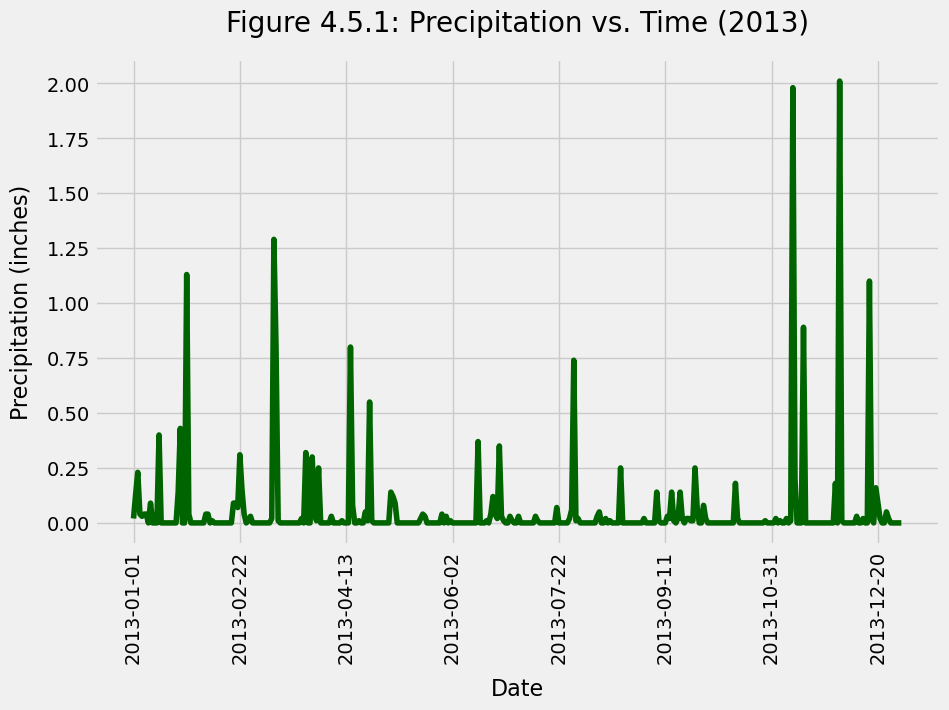

In [51]:
matplotlibx.display_plot_from_series \
    (precipitation_series_list[3], 'Figure 4.5.1: Precipitation vs. Time (2013)',
     'darkgreen', 'Date', 'Precipitation (inches)')

### **Histogram**

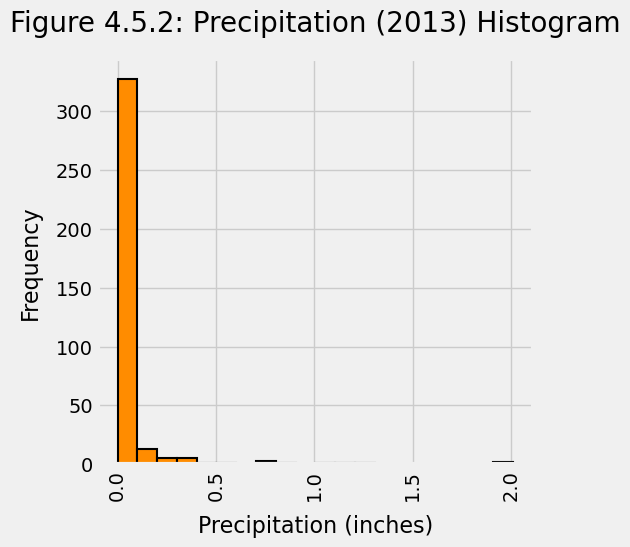

In [52]:
matplotlibx.display_histogram_from_series \
    (precipitation_series_list[3],
     'Figure 4.5.2: Precipitation (2013) Histogram',
     ['darkorange'], 'Precipitation (inches)', 'Frequency',  
     figure_width_float = 5.0, figure_length_float = 5.0)

### **Summary Statistics**

In [53]:
pandasx.return_statistics_styler_from_series \
    (precipitation_series_list[3], 'Table 4.5: Precipitation (2013) Summary Statistics')

,2013
mean,0.0532
median,0.0000
mode,0.0000
variance,0.0431
std_dev,0.2076
sem,0.0109
minimum,0.00
25%,0.00
50%,0.00
75%,0.02


## **4.6: Precipitation (2014)**

### **Display Precipitation vs. Time**

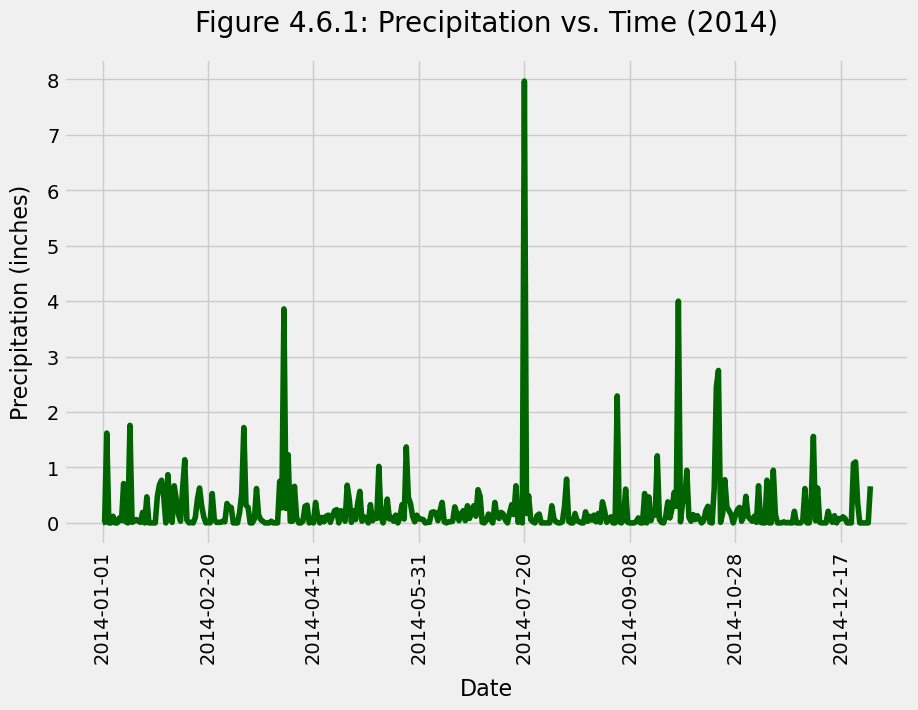

In [54]:
matplotlibx.display_plot_from_series \
    (precipitation_series_list[4], 'Figure 4.6.1: Precipitation vs. Time (2014)',
     'darkgreen', 'Date', 'Precipitation (inches)')

### **Histogram**

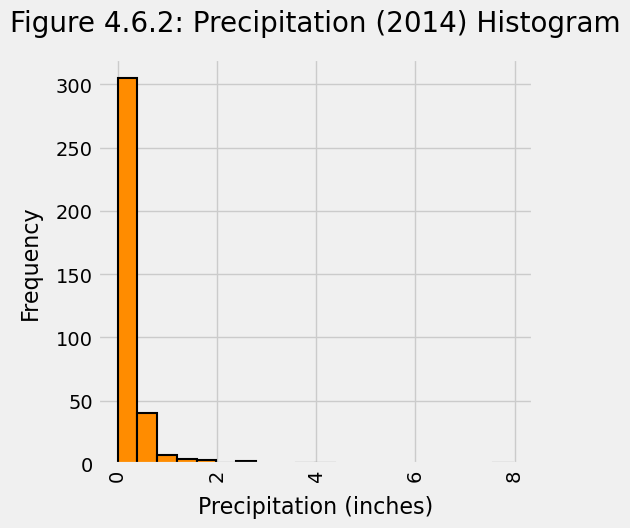

In [55]:
matplotlibx.display_histogram_from_series \
    (precipitation_series_list[4],
     'Figure 4.6.2: Precipitation (2014) Histogram',
     ['darkorange'], 'Precipitation (inches)', 'Frequency',  
     figure_width_float = 5.0, figure_length_float = 5.0)

### **Summary Statistics**

In [56]:
pandasx.return_statistics_styler_from_series \
    (precipitation_series_list[4], 'Table 4.6: Precipitation (2014) Summary Statistics')

,2014
mean,0.2462
median,0.0700
mode,0.0000
variance,0.3678
std_dev,0.6065
sem,0.0317
minimum,0.00
25%,0.00
50%,0.07
75%,0.26


## **4.7: Precipitation (2015)**

### **Display Precipitation vs. Time**

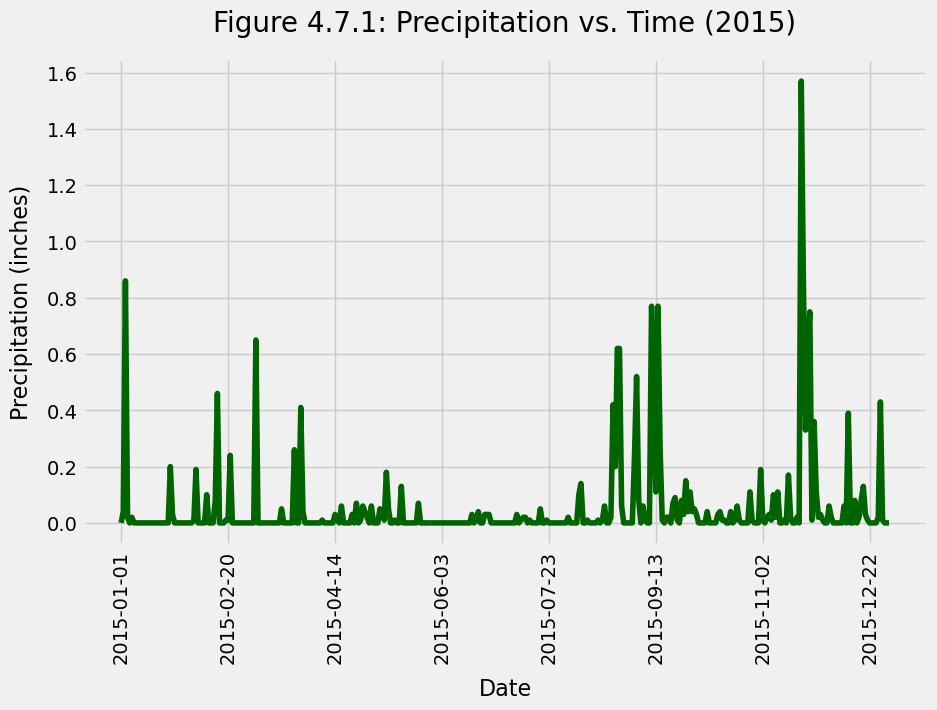

In [57]:
matplotlibx.display_plot_from_series \
    (precipitation_series_list[5], 'Figure 4.7.1: Precipitation vs. Time (2015)',
     'darkgreen', 'Date', 'Precipitation (inches)')

### **Histogram**

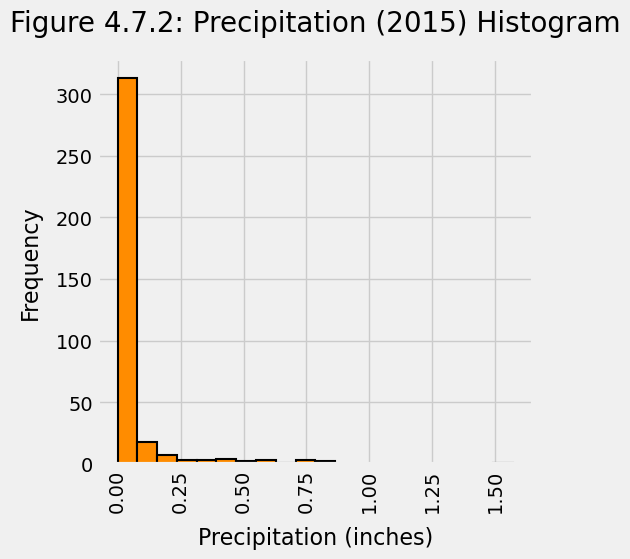

In [58]:
matplotlibx.display_histogram_from_series \
    (precipitation_series_list[5],
     'Figure 4.7.2: Precipitation (2015) Histogram',
     ['darkorange'], 'Precipitation (inches)', 'Frequency',  
     figure_width_float = 5.0, figure_length_float = 5.0)

### **Summary Statistics**

In [59]:
pandasx.return_statistics_styler_from_series \
    (precipitation_series_list[5], 'Table 4.7: Precipitation (2015) Summary Statistics')

,2015
mean,0.0510
median,0.0000
mode,0.0000
variance,0.0243
std_dev,0.1559
sem,0.0082
minimum,0.00
25%,0.00
50%,0.00
75%,0.02


## **4.8: Precipitation (2016)**

### **Display Precipitation vs. Time**

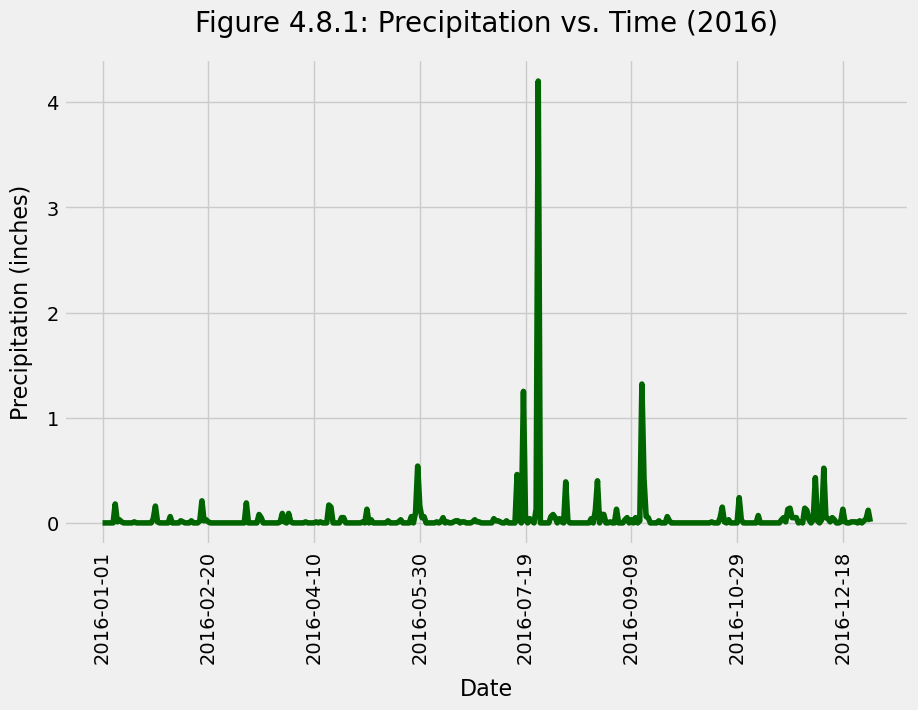

In [60]:
matplotlibx.display_plot_from_series \
    (precipitation_series_list[6], 'Figure 4.8.1: Precipitation vs. Time (2016)',
     'darkgreen', 'Date', 'Precipitation (inches)')

### **Histogram**

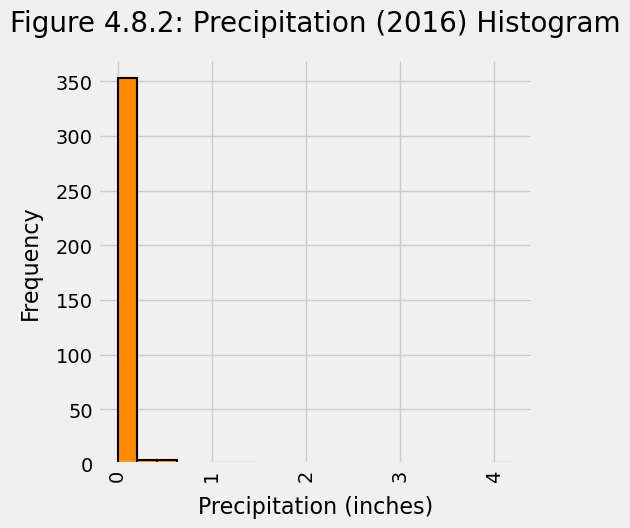

In [61]:
matplotlibx.display_histogram_from_series \
    (precipitation_series_list[6],
     'Figure 4.8.2: Precipitation (2016) Histogram',
     ['darkorange'], 'Precipitation (inches)', 'Frequency',  
     figure_width_float = 5.0, figure_length_float = 5.0)

### **Summary Statistics**

In [62]:
pandasx.return_statistics_styler_from_series \
    (precipitation_series_list[6], 'Table 4.8: Precipitation (2016) Summary Statistics')

,2016
mean,0.0444
median,0.0000
mode,0.0000
variance,0.0614
std_dev,0.2478
sem,0.0130
minimum,0.00
25%,0.00
50%,0.00
75%,0.02


## **4.9: Precipitation (2017 - 8 Months)**

### **Display Precipitation vs. Time**

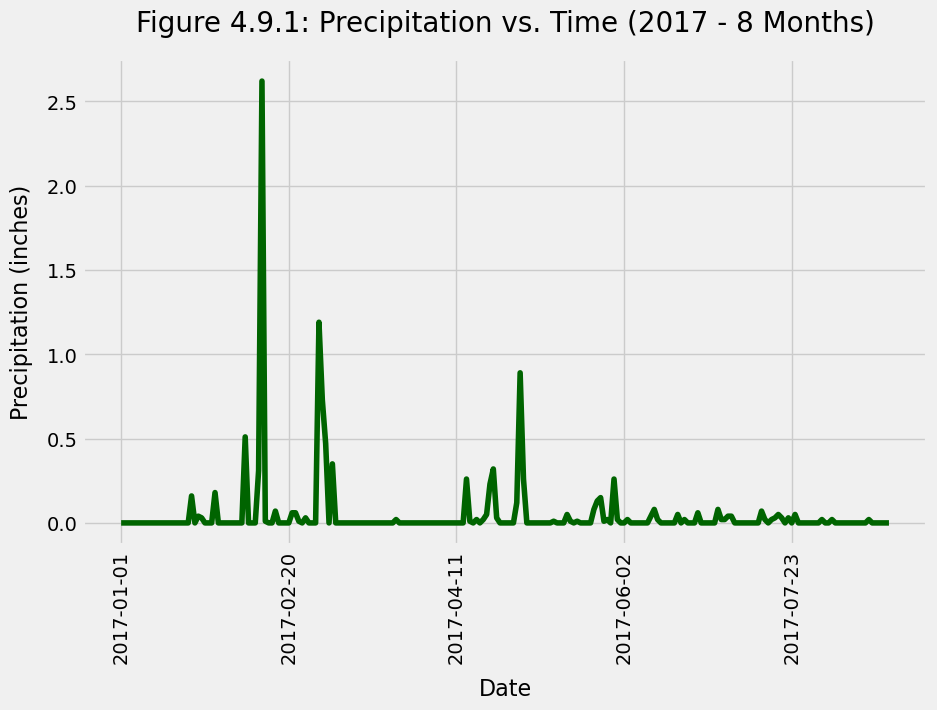

In [63]:
matplotlibx.display_plot_from_series \
    (precipitation_series_list[7], 'Figure 4.9.1: Precipitation vs. Time (2017 - 8 Months)',
     'darkgreen', 'Date', 'Precipitation (inches)')

### **Histogram**

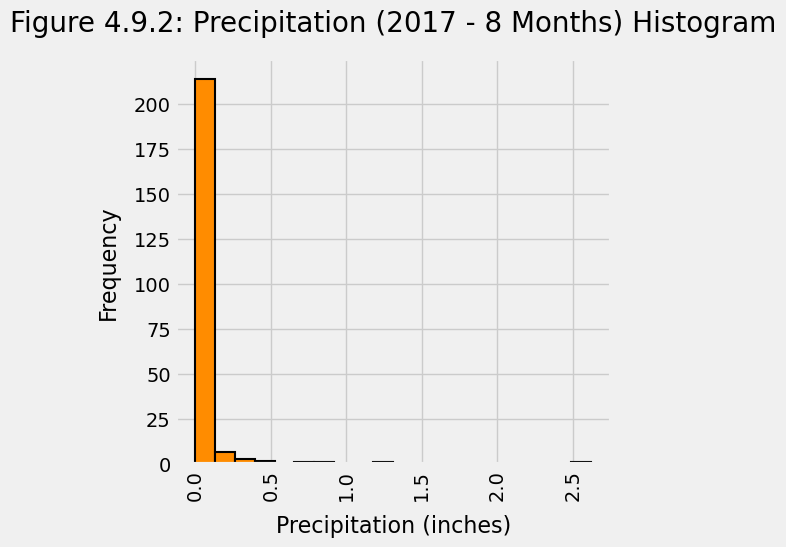

In [64]:
matplotlibx.display_histogram_from_series \
    (precipitation_series_list[7],
     'Figure 4.9.2: Precipitation (2017 - 8 Months) Histogram',
     ['darkorange'], 'Precipitation (inches)', 'Frequency',  
     figure_width_float = 5.0, figure_length_float = 5.0)

### **Summary Statistics**

In [65]:
pandasx.return_statistics_styler_from_series \
    (precipitation_series_list[7], 'Table 4.9: Precipitation (2017 - 8 Months) Summary Statistics')

,2017*
mean,0.0463
median,0.0000
mode,0.0000
variance,0.0452
std_dev,0.2126
sem,0.0140
minimum,0.00
25%,0.00
50%,0.00
75%,0.01


## **4.10: Precipitation (2010-2017)**

### **Display Precipitation vs. Time**

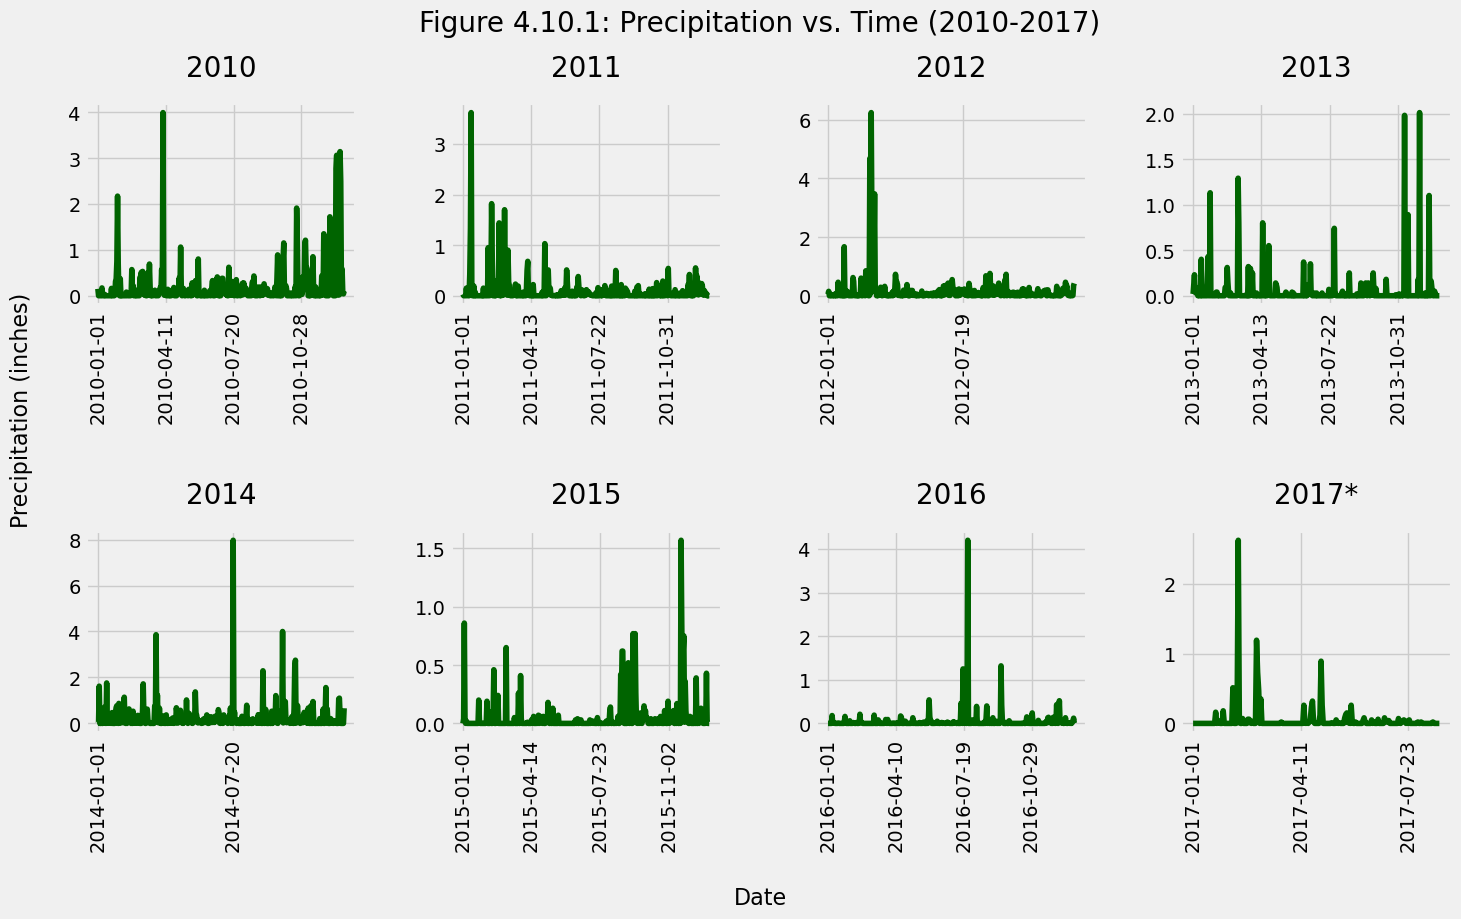

In [66]:
matplotlibx.display_plots_from_series_list \
    (precipitation_series_list, 
     'Figure 4.10.1: Precipitation vs. Time (2010-2017)', 
     'Date', 'Precipitation (inches)')

### **Histogram**

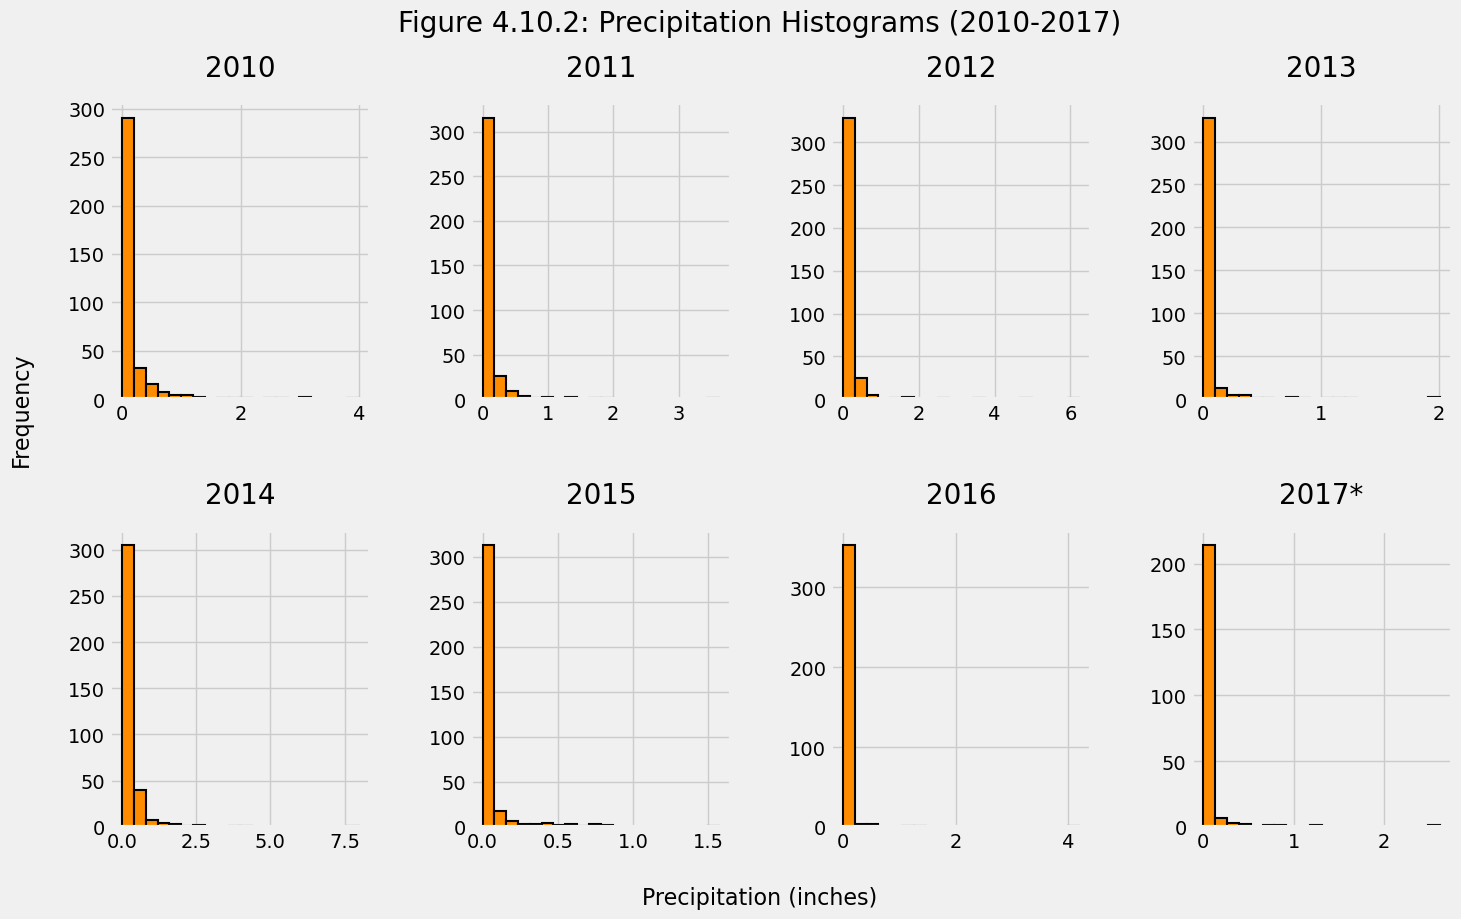

In [67]:
matplotlibx.display_histograms_from_series_list \
    (precipitation_series_list,
     'Figure 4.10.2: Precipitation Histograms (2010-2017)',
     'Precipitation (inches)', 'Frequency', color_string = 'darkorange',
     figure_width_float = 15.0, figure_length_float = 10.0)

### **Box Plot**

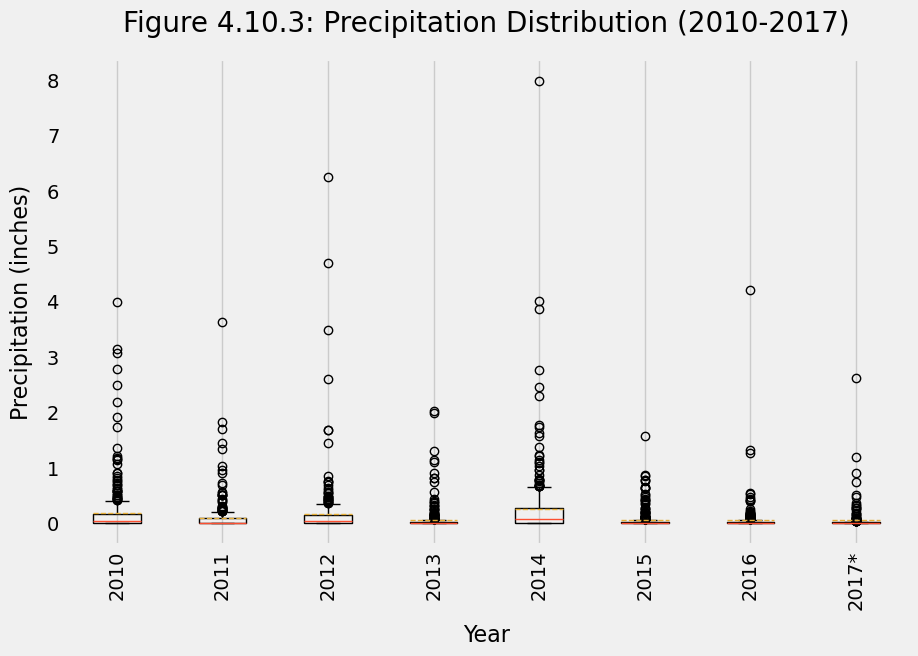

In [68]:
matplotlibx.display_boxplots_from_series_list \
    (precipitation_series_list, climate_analysis_constants.year_string_list,
     'Figure 4.10.3: Precipitation Distribution (2010-2017)', 
     'Year', 'Precipitation (inches)', xticks_rotation_float = 90.0)

### **Summary Statistics**

In [69]:
pandasx.return_statistics_styler_from_series_list \
    (precipitation_series_list, 'Table 4.10.1: Temperature Observations (TOBs) Statistics (2010-2017)')

,2010,2011,2012,2013,2014,2015,2016,2017*
mean,0.1805,0.0909,0.1500,0.0532,0.2462,0.0510,0.0444,0.0463
median,0.0250,0.0050,0.0300,0.0000,0.0700,0.0000,0.0000,0.0000
mode,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
variance,0.1962,0.0786,0.2453,0.0431,0.3678,0.0243,0.0614,0.0452
std_dev,0.4429,0.2803,0.4952,0.2076,0.6065,0.1559,0.2478,0.2126
sem,0.0232,0.0147,0.0259,0.0109,0.0317,0.0082,0.0130,0.0140
minimum,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.03,0.01,0.03,0.00,0.07,0.00,0.00,0.00
75%,0.16,0.08,0.14,0.02,0.26,0.02,0.02,0.01


### **Correlation Matrix**

In [70]:
omit_series_index = len(precipitation_series_list) - 1

normalized_precipitation_dataframe \
    = timex.return_normalized_series_list_as_dataframe(precipitation_series_list, [omit_series_index])

pandasx.return_formatted_table \
    (normalized_precipitation_dataframe.corr(), 
     'Table 4.10.2: Precipitation Correlation Matrix (2010-2016)',
     hide_index_boolean = False)

,2010,2011,2012,2013,2014,2015,2016
2010,1.00,0.05,0.01,0.00,0.01,-0.05,-0.02
2011,0.05,1.00,0.04,0.01,-0.02,-0.06,-0.02
2012,0.01,0.04,1.00,0.11,0.01,0.09,-0.01
2013,0.00,0.01,0.11,1.00,-0.02,-0.03,-0.02
2014,0.01,-0.02,0.01,-0.02,1.00,-0.02,-0.04
2015,-0.05,-0.06,0.09,-0.03,-0.02,1.00,0.06
2016,-0.02,-0.02,-0.01,-0.02,-0.04,0.06,1.00


## **4.11: Total Precipitation (2010-2017)**

### **Calculations**

In [71]:
total_precipitation_dataframe \
    = pd.DataFrame.from_dict \
        (climate_analysis_constants.total_precipitation_dictionary, 
         orient = 'index', columns = ['precipitation'])

logx.log_write_object(total_precipitation_dataframe)

### **Display Total Precipitation vs. Year**

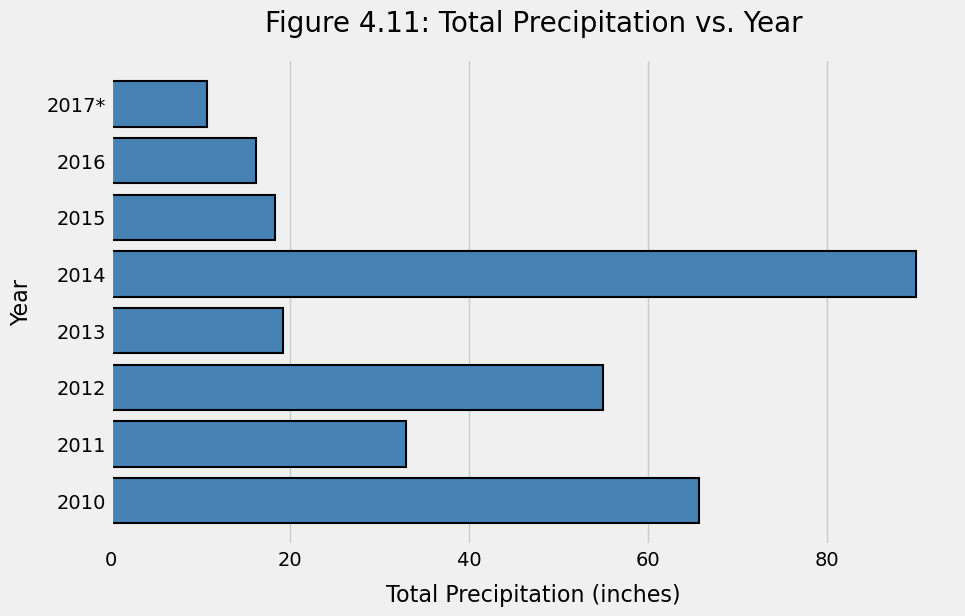

In [72]:
matplotlibx.display_bar_chart_from_series \
    (total_precipitation_dataframe.squeeze(), 'Figure 4.11: Total Precipitation vs. Year',
     'Total Precipitation (inches)', 'Year', 'steelblue', 
     horizontal_boolean = True,  xtick_label_rotation_float = 0.0)

In [73]:
pandasx.return_formatted_table \
    (total_precipitation_dataframe, 
     'Table 4.11.1: Total Precipitation (inches) vs. Year (2010-2017)',
     hide_index_boolean = False)

,precipitation
2010,65.69
2011,32.90
2012,54.90
2013,19.25
2014,89.85
2015,18.36
2016,16.15
2017*,10.66


### **Summary Statistics**

In [74]:
pandasx.return_statistics_styler_from_series \
    (total_precipitation_dataframe['precipitation'], 'Table 4.11.2: Total Precipitation Statistics (2010-2017)')

,precipitation
mean,38.4700
median,26.0750
mode,10.6600
variance,818.1717
std_dev,28.6037
sem,10.1129
minimum,10.66
25%,17.81
50%,26.07
75%,57.60


# Section 5: Close Session

In [75]:
session_sqlalchemy.close()

In [76]:
# logx.end_program()